In [1]:
import cv2  # For image manipulation and drawing circles
import numpy as np  # For numerical operations and array handling
import pandas as pd  # For handling CSVs and data storage
import os  # For directory operations (optional if not used explicitly)
from pathlib import Path  # For file and directory path handling
from typing import Tuple, List, Dict, Set  # For type hinting
import random  # For generating random numbers and shuffling
import matplotlib.pyplot as plt  # For displaying sample images
from dataclasses import dataclass  # For creating configuration class


Dataset generation completed successfully!


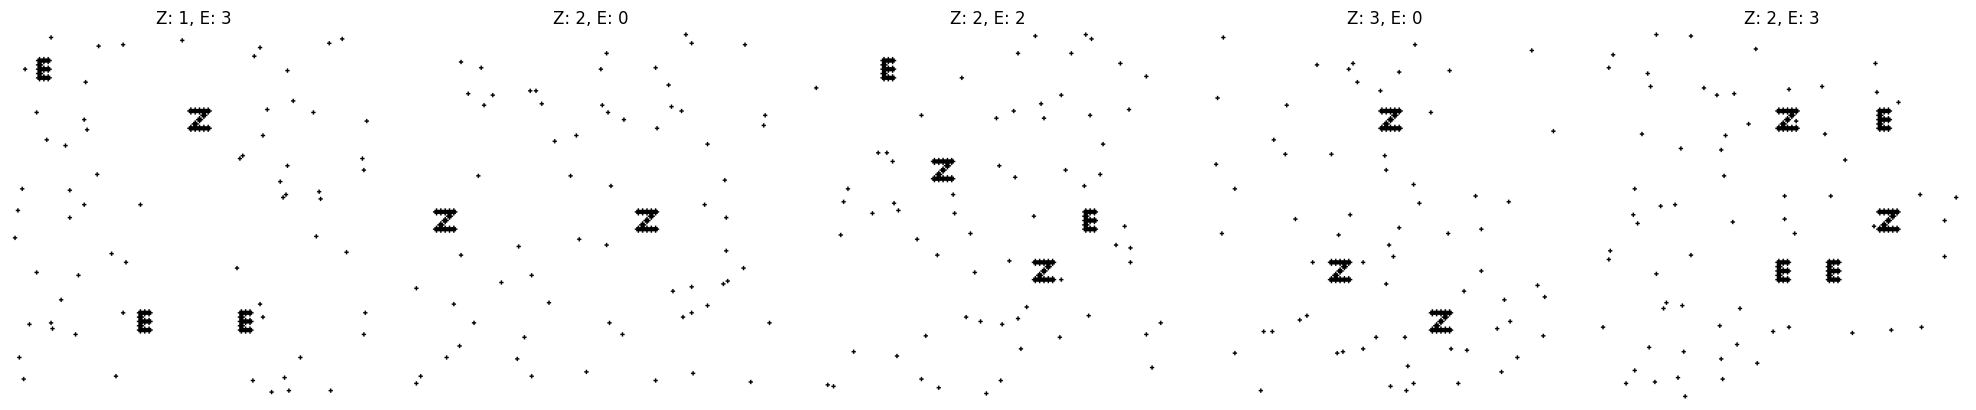

In [2]:
import cv2
import numpy as np
import pandas as pd
import os
from pathlib import Path
from typing import Tuple, List, Dict, Set
import random
import matplotlib.pyplot as plt
from dataclasses import dataclass

@dataclass
class DatasetConfig:
    """Configuration parameters for dataset generation."""
    dataset_name: str = "letters_dataset"
    letter_size: int = 2  # Reduced from 5 to 2
    spacing_between_circles: int = 5  # Reduced from 15 to 8
    random_dot_density: float = 0.1
    image_size: int = 128
    num_samples: int = 1000
    train_ratio: float = 0.8
    padding: int = 8  # Reduced from 10 to 8
    min_letters: int = 2
    max_letters: int = 5

    def __post_init__(self):
        # Calculate the space needed for letters
        self.letter_width_T = 5 * self.spacing_between_circles  # E needs 5 circles horizontally
        self.letter_height_T = 5 * self.spacing_between_circles  # E needs 5 circles vertically
        self.letter_width_I = self.spacing_between_circles  # Z needs 1 circle horizontally
        self.letter_height_I = 5 * self.spacing_between_circles  # Z needs 5 circles vertically

        # Calculate cell size based on the larger letter (T)
        self.cell_size = max(self.letter_width_T, self.letter_height_T) + self.padding

        # Validate configuration
        max_letters_possible = ((self.image_size - self.padding * 2) // self.cell_size) ** 2
        if max_letters_possible < self.max_letters:
            raise ValueError(f"Image size too small for {self.max_letters} letters. Maximum possible: {max_letters_possible}")

class LetterDrawer:
    """Handles drawing of letters in images."""

    def __init__(self, image_size: int, letter_size: int):
        self.image_size = image_size
        self.letter_size = letter_size

    def _is_valid_position(self, x: int, y: int) -> bool:
        """Check if position is within image bounds."""
        return 0 <= x < self.image_size and 0 <= y < self.image_size

    def draw_Z(self, image: np.ndarray, x: int, y: int, gap: int) -> Set[Tuple[int, int]]:
      occupied_positions = set()

    # Draw the top horizontal line of 'Z'
      for i in range(5):
        center_x = x + i * gap
        if self._is_valid_position(center_x, y):
            cv2.circle(image, (center_x, y), self.letter_size, (0, 00, 0), -1)
            for dy in range(-self.letter_size, self.letter_size + 1):
                for dx in range(-self.letter_size, self.letter_size + 1):
                    occupied_positions.add((center_x + dx, y + dy))

    # Draw the diagonal line of 'Z'
      for i in range(5):
        center_x = x + i * gap
        center_y = y + (4 - i) * gap  # Invert the y-coordinate to create the correct diagonal
        if self._is_valid_position(center_x, center_y):
          cv2.circle(image, (center_x, center_y), self.letter_size, (0, 00, 0), -1)
          for dy in range(-self.letter_size, self.letter_size + 1):
            for dx in range(-self.letter_size, self.letter_size + 1):
                occupied_positions.add((center_x + dx, center_y + dy))

    # Draw the bottom horizontal line of 'Z'
      for i in range(5):
        center_x = x + i * gap
        bottom_y = y + 4 * gap  # Bottom line is offset by 4 gaps vertically
        if self._is_valid_position(center_x, bottom_y):
            cv2.circle(image, (center_x, bottom_y), self.letter_size, (0, 00, 0), -1)
            for dy in range(-self.letter_size, self.letter_size + 1):
                for dx in range(-self.letter_size, self.letter_size + 1):
                    occupied_positions.add((center_x + dx, bottom_y + dy))

      return occupied_positions

    def draw_E(self, image: np.ndarray, x: int, y: int, gap: int) -> Set[Tuple[int, int]]:
        """
        Draws the letter 'E' with circles and returns the set of occupied positions.
        """
        occupied_positions = set()

        # Draw vertical line of 'E'
        for j in range(5):
            center_y = y + j * gap
            if self._is_valid_position(x, center_y):
                cv2.circle(image, (x, center_y), self.letter_size, (0, 0, 0), -1)
                for dy in range(-self.letter_size, self.letter_size + 1):
                    for dx in range(-self.letter_size, self.letter_size + 1):
                        occupied_positions.add((x + dx, center_y + dy))

        # Draw horizontal lines of 'E'
        for i in [0, 2, 4]:  # Top, middle, and bottom lines
            center_y = y + i * gap
            for k in range(3):
                center_x = x + k * gap
                if self._is_valid_position(center_x, center_y):
                    cv2.circle(image, (center_x, center_y), self.letter_size, (0, 0, 0), -1)
                    for dy in range(-self.letter_size, self.letter_size + 1):
                        for dx in range(-self.letter_size, self.letter_size + 1):
                            occupied_positions.add((center_x + dx, center_y + dy))

        return occupied_positions

class ImageGenerator:
    """Handles generation of images with letters and noise."""

    def __init__(self, config: DatasetConfig):
        self.config = config
        self.letter_drawer = LetterDrawer(config.image_size, config.letter_size)

    def generate_single_image(self) -> Tuple[np.ndarray, Dict[str, int]]:
        """Generates a single image with letters and returns the image and letter counts."""
        img = np.ones((self.config.image_size, self.config.image_size, 3), dtype=np.uint8) * 255
        grid_positions = self.generate_grid_positions()
        letter_counts = {'Z': 0, 'E': 0}
        occupied_positions = set()

        total_letters = random.randint(self.config.min_letters, min(self.config.max_letters, len(grid_positions)))

        for _ in range(total_letters):
            if not grid_positions:
                break

            x, y = grid_positions.pop()
            letter_type = random.choice(['Z', 'E'])

            new_occupied = set()
            if letter_type == 'Z':
                new_occupied = self.letter_drawer.draw_Z(img, x, y, self.config.spacing_between_circles)
                letter_counts['Z'] += 1
            else:
                new_occupied = self.letter_drawer.draw_E(img, x, y, self.config.spacing_between_circles)
                letter_counts['E'] += 1

            occupied_positions.update(new_occupied)

        self.scatter_random_dots(img, occupied_positions)
        return img, letter_counts

    def scatter_random_dots(self, image: np.ndarray, occupied_positions: Set[Tuple[int, int]]) -> None:
        """Adds random noise dots to the image, avoiding letter positions."""
        num_dots = int(self.config.random_dot_density * self.config.image_size * self.config.image_size)

        dots_placed = 0
        max_attempts = num_dots * 4  # Limit attempts to avoid infinite loops
        attempts = 0

        while dots_placed < num_dots and attempts < max_attempts:
            x = random.randint(2, self.config.image_size - 3)
            y = random.randint(2, self.config.image_size - 3)

            # Check if position is occupied by a letter
            position_free = True
            for dx in range(-1, 2):
                for dy in range(-1, 2):
                    if (x + dx, y + dy) in occupied_positions:
                        position_free = False
                        break
                if not position_free:
                    break

            if position_free and np.all(image[y-1:y+2, x-1:x+2] == 255):
                cv2.circle(image, (x, y), 1, (0, 0, 0), -1)
                dots_placed += 1

            attempts += 1

    def generate_grid_positions(self) -> List[Tuple[int, int]]:
        """Generates possible non-overlapping positions for letters."""
        positions = []
        for i in range(self.config.padding,
                      self.config.image_size - self.config.padding - self.config.cell_size,
                      self.config.cell_size):
            for j in range(self.config.padding,
                           self.config.image_size - self.config.padding - self.config.cell_size,
                           self.config.cell_size):
                positions.append((i, j))

        random.shuffle(positions)
        return positions


class DatasetGenerator:
    """Manages the generation and saving of the complete dataset."""

    def __init__(self, config: DatasetConfig):
        self.config = config
        self.image_generator = ImageGenerator(config)

    def setup_directories(self) -> Tuple[Path, Path]:
        """Creates and returns paths for train and test directories."""
        output_dir = Path(self.config.dataset_name)
        train_dir = output_dir / "train"
        test_dir = output_dir / "test"

        train_dir.mkdir(parents=True, exist_ok=True)
        test_dir.mkdir(parents=True, exist_ok=True)

        return train_dir, test_dir

    def generate_dataset(self) -> Tuple[Path, Path]:
        """Generates complete dataset with training and testing splits."""
        train_dir, test_dir = self.setup_directories()
        num_train = int(self.config.num_samples * self.config.train_ratio)

        self._generate_split(train_dir, num_train, "training")
        self._generate_split(test_dir, self.config.num_samples - num_train, "testing")

        return train_dir, test_dir

    def _generate_split(self, output_dir: Path, num_samples: int, split_name: str) -> None:
      csv_data = []

      for i in range(num_samples):
        img, letter_counts = self.image_generator.generate_single_image()
        filename = f"img_{i:05d}.png"
        cv2.imwrite(str(output_dir / filename), img)

        # Ensure correct labels for 'E' and 'Z'
        csv_data.append([filename, letter_counts['Z'], letter_counts['E']])

        if (i + 1) % 100 == 0:
            print(f"Generated {i + 1}/{num_samples} {split_name} images")

    # Save labels
      df = pd.DataFrame(csv_data, columns=["filename", "num_Z", "num_E"])
      df.to_csv(output_dir / "labels.csv", index=False)

def display_sample_images(dataset_dir: Path, num_samples: int = 5) -> None:
    """Displays random samples from the specified dataset directory."""
    labels = pd.read_csv(dataset_dir / "labels.csv")
    samples = labels.sample(n=min(num_samples, len(labels)))

    fig, axes = plt.subplots(1, len(samples), figsize=(4 * len(samples), 4))
    if len(samples) == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, samples.iterrows()):
        img = cv2.imread(str(dataset_dir / row['filename']))
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(f"Z: {row['num_Z']}, E: {row['num_E']}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Usage Example
if __name__ == "__main__":
    config = DatasetConfig(
        dataset_name="letter_dataset",
        letter_size=2,
        spacing_between_circles=3,
        random_dot_density=0.001,
        image_size=256,
        num_samples=100,
        min_letters=2,
        max_letters=5,
        train_ratio=0.8,
        padding=20,
    )

    try:
        generator = DatasetGenerator(config)
        train_dir, test_dir = generator.generate_dataset()
        print("Dataset generation completed successfully!")

        # Display sample images from the training dataset
        display_sample_images(train_dir, num_samples=5)

    except Exception as e:
        print(f"Error generating dataset: {str(e)}")



# Usage Example remains the same.


Dataset generation completed successfully!


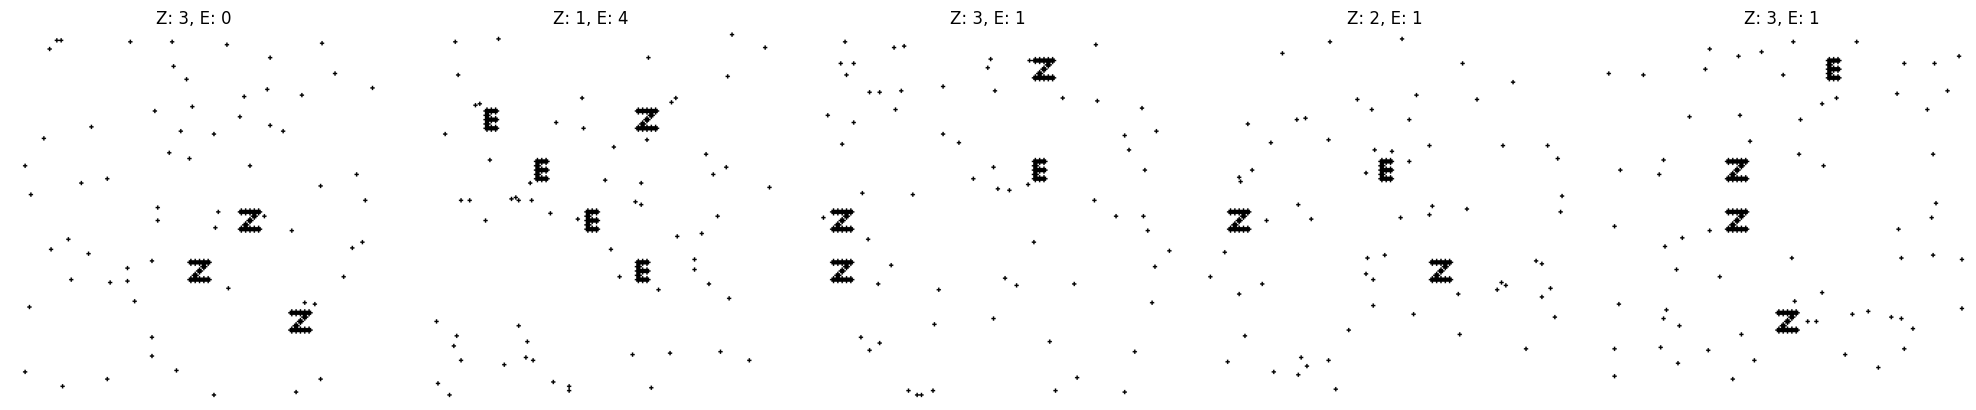

In [3]:
config = DatasetConfig(
        dataset_name="dataset_1",
        letter_size=2,
        spacing_between_circles=3,
        random_dot_density=0.001,
        image_size=256,
        num_samples=100,
        min_letters=2,
        max_letters=5,
        train_ratio=0.8,
        padding=20,
    )
try:
        generator = DatasetGenerator(config)
        train1_dir, test1_dir = generator.generate_dataset()
        print("Dataset generation completed successfully!")

        # Display sample images from the training dataset
        display_sample_images(train1_dir, num_samples=5)

except Exception as e:
        print(f"Error generating dataset: {str(e)}")

Dataset generation completed successfully!


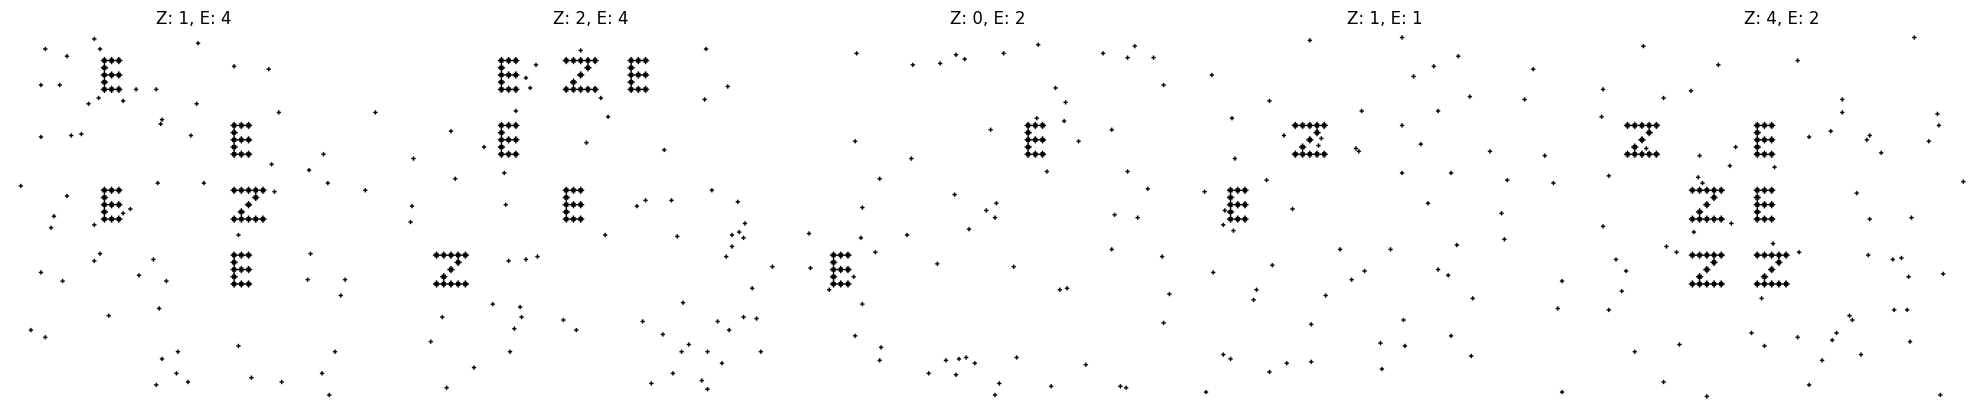

In [4]:
config = DatasetConfig(
        dataset_name="dataset_2",
        letter_size=2,
        spacing_between_circles=5,
        random_dot_density=0.001,
        image_size=256,
        num_samples=100,
        min_letters=2,
        max_letters=6,
        train_ratio=0.8,
        padding=20,
    )
try:
        generator = DatasetGenerator(config)
        train2_dir, test2_dir = generator.generate_dataset()
        print("Dataset generation completed successfully!")

        # Display sample images from the training dataset
        display_sample_images(train2_dir, num_samples=5)

except Exception as e:
        print(f"Error generating dataset: {str(e)}")

Dataset generation completed successfully!


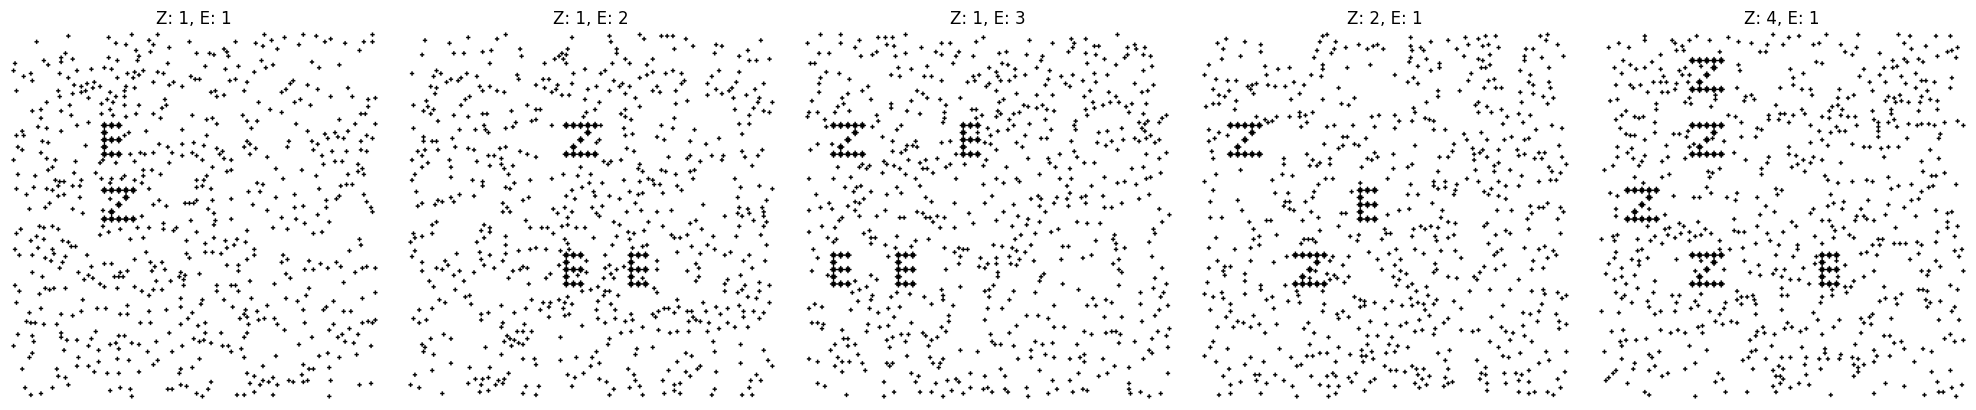

In [5]:
config = DatasetConfig(
        dataset_name="dataset_3",
        letter_size=2,
        spacing_between_circles=5,
        random_dot_density=0.01,
        image_size=256,
        num_samples=100,
        min_letters=2,
        max_letters=6,
        train_ratio=0.8,
        padding=20,
    )
try:
        generator = DatasetGenerator(config)
        train3_dir, test3_dir = generator.generate_dataset()
        print("Dataset generation completed successfully!")

        # Display sample images from the training dataset
        display_sample_images(train3_dir, num_samples=5)

except Exception as e:
        print(f"Error generating dataset: {str(e)}")

Dataset generation completed successfully!


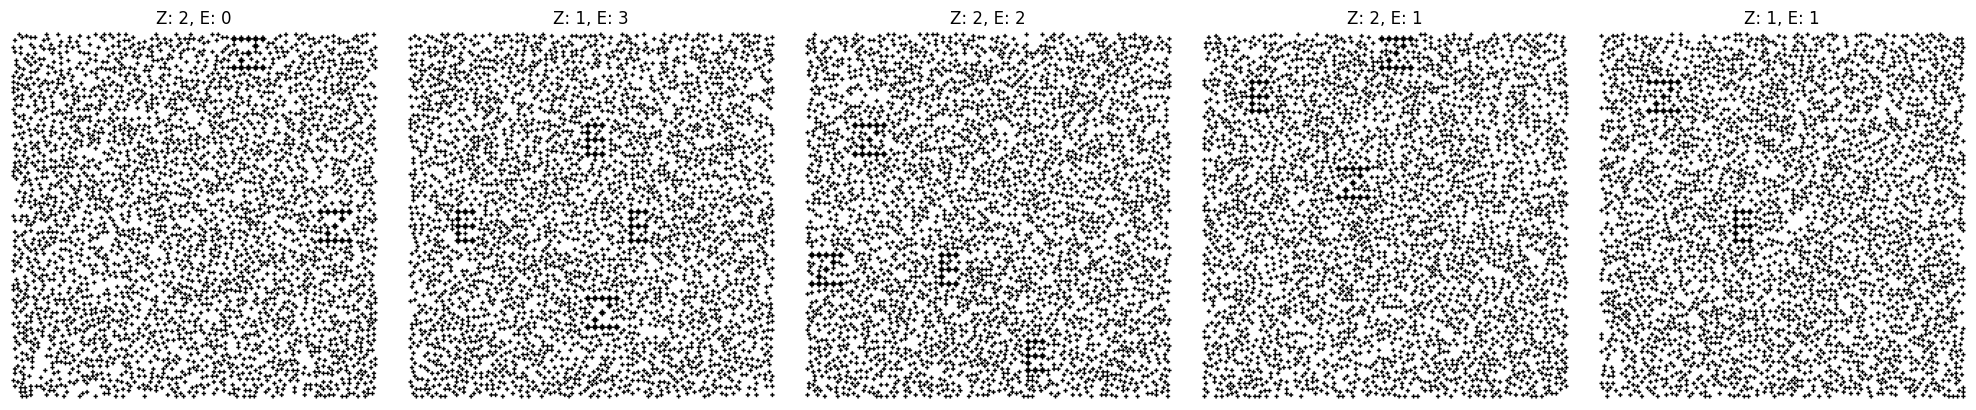

In [6]:
config = DatasetConfig(
        dataset_name="dataset_4",
        letter_size=2,
        spacing_between_circles=5,
        random_dot_density=0.05,
        image_size=256,
        num_samples=100,
        min_letters=2,
        max_letters=5,
        train_ratio=0.8,
        padding=5,
    )
try:
        generator = DatasetGenerator(config)
        train4_dir, test4_dir = generator.generate_dataset()
        print("Dataset generation completed successfully!")

        # Display sample images from the training dataset
        display_sample_images(train4_dir, num_samples=5)

except Exception as e:
        print(f"Error generating dataset: {str(e)}")

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

# Define the custom dataset class for your data
class LetterDataset(Dataset):
    def __init__(self, folder, csv_file, transform=None):
        self.folder = folder
        self.labels = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        row = self.labels.iloc[index]
        image_file = os.path.join(self.folder, row['filename'])
        image = Image.open(image_file).convert('L')  # Convert image to grayscale
        label = 0 if row['num_E'] > 0 else 1  # Label as 0 for 'E', 1 for 'Z'

        if self.transform:
            image = self.transform(image)

        return image, label

# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):  # 2 classes for 'E' and 'Z'
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Updated input size for fc1 based on the flattened size
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))  # First conv + activation + pooling
        x = self.pool(nn.ReLU()(self.conv2(x)))  # Second conv + activation + pooling

        print(x.shape)  # Debugging: Check shape after pooling

        x = x.view(x.size(0), -1)  # Flatten tensor
        x = nn.ReLU()(self.fc1(x))  # Fully connected layer + activation
        x = self.fc2(x)  # Output layer

        return x


# Setup for device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=2).to(device)

# Define the transformations
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load the datasets using your CSV labels
train_dataset = LetterDataset('dataset_1/train', 'dataset_1/train/labels.csv', transform=image_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

test_dataset = LetterDataset('dataset_1/test', 'dataset_1/test/labels.csv', transform=image_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the CNN model
def train_model(model, data_loader, loss_fn, optimizer, epochs=10):
    model.train()
    for images, labels in data_loader:
      print(f"Images: {images.shape}, Labels: {labels.shape}")
      break  # Check one batch to confirm shapes are correct


    for epoch in range(epochs):
        running_loss = 0.0
        correct_preds = 0
        total_samples = 0

        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            running_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_preds += (predictions == labels).sum().item()

        accuracy = 100 * correct_preds / total_samples
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(data_loader):.4f}, Accuracy: {accuracy:.2f}%")

# Train the model
train_model(model, train_loader, loss_function, optimizer)

# Test the model
def test_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

# Evaluate on test data
test_model(model, test_loader)


Images: torch.Size([32, 1, 128, 128]), Labels: torch.Size([32])
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [1/10], Loss: 0.5672, Accuracy: 87.50%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [2/10], Loss: 1.9733, Accuracy: 85.94%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [3/10], Loss: 0.6012, Accuracy: 87.50%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [4/10], Loss: 0.5178, Accuracy: 87.50%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [5/10], Loss: 0.5012, Accuracy: 89.06%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [6/10], Loss: 0.4125, Accuracy: 87.50%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [7/10], Loss: 0.3966, Accuracy: 87.50%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [8/10], Loss: 0.4003, Accuracy: 87.50%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [9/10], Loss: 0.4172, Accuracy: 85.94%
torch.Siz

In [8]:
# List of dataset paths
datasets = [
    ("dataset_1", "dataset_1/train/labels.csv", "dataset_1/test/labels.csv"),
    ("dataset_2", "dataset_2/train/labels.csv", "dataset_2/test/labels.csv"),
    ("dataset_3", "dataset_3/train/labels.csv", "dataset_3/test/labels.csv"),
    ("dataset_4", "dataset_4/train/labels.csv", "dataset_4/test/labels.csv"),
]

# Loop through each dataset and train/test the model
for dataset_name, train_csv, test_csv in datasets:
    print(f"\nTraining and Testing on {dataset_name}")

    # Load the datasets using your CSV labels
    train_dataset = LetterDataset(f'{dataset_name}/train', train_csv, transform=image_transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

    test_dataset = LetterDataset(f'{dataset_name}/test', test_csv, transform=image_transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Reinitialize the model and optimizer for each dataset
    model = SimpleCNN(num_classes=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    print(f"Training on {dataset_name}")
    train_model(model, train_loader, loss_function, optimizer)

    # Test the model
    print(f"Testing on {dataset_name}")
    test_model(model, test_loader)



Training and Testing on dataset_1
Training on dataset_1
Images: torch.Size([32, 1, 128, 128]), Labels: torch.Size([32])
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [1/10], Loss: 0.3525, Accuracy: 60.94%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [2/10], Loss: 3.4678, Accuracy: 89.06%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [3/10], Loss: 1.5926, Accuracy: 89.06%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [4/10], Loss: 0.6249, Accuracy: 46.88%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [5/10], Loss: 0.4941, Accuracy: 89.06%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [6/10], Loss: 0.4587, Accuracy: 84.38%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [7/10], Loss: 0.4936, Accuracy: 84.38%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32])
Epoch [8/10], Loss: 0.3684, Accuracy: 87.50%
torch.Size([32, 64, 32, 32])
torch.Size([32, 64, 32, 32